# Projeto 04 - Amazon

Problema: a empresa gostaria de avaliar quais fatores influenciam na classificação de um produto (rating).

Variáveis a se considerar:

- Percentual de desconto (discount_percentage);
- Avaliação de satisfação do cliente (score_sentimento);
- Contagem de avaliações (rating_count);


# Análise de sentimento:

Dentro do campo do Processamento de Linguagem Natural (PLN), esta técnica envolve a identificação e extração de informações subjetivas em textos. O principal objetivo é determinar se o sentimento expresso em um texto é positivo, negativo ou neutro. No caso deste projeto, serve para analisar opiniões de consumidores sobre produtos da Amazon.

Neste trabalho será utilizada a biblioteca Natural Language Toolkit (NLTK), que tem um módulo chamado VADER (Valence Aware Dictionary and Sentiment Reasoner) que é bom para análises de sentimento em textos.



In [ ]:
!pip install google-cloud-bigquery
!pip install langdetect
!pip install textblob
!pip install unidecode
!pip install nltk

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
import re
from langdetect import detect
import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

# Configurar o cliente BigQuery
project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT product_id, review_content
FROM `projeto04-amazon.amazon.amazon_dummy`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])

# Convertendo para string
df['review_content'] = df['review_content'].astype(str)

# Detectar idioma antes de limpar o texto
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

# Aplicar a detecção de linguagem e filtrar para apenas reviews em inglês
df = df[df['review_content'].apply(detect_language) == 'en']

# Limpar texto
def clean_text(text):
    # Adicionar espaço após cada vírgula
    text = re.sub(r',', ', ', text)

    # Remover links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remover datas
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '', text)

    # Remover valores monetários
    text = re.sub(r'\$\d+(?:\.\d+)?|\d+(?:\.\d+)?\s?USD', '', text)

    # Remover valores numéricos
    text = re.sub(r'\b\d+\b', '', text)

    # Remover caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)

    # Converter letras para minúsculo
    text = text.lower()

    # Remover acentos
    text = unidecode.unidecode(text)

    # Remover stop words (palavras comuns que não carregam muito significado, como "and", "the", etc.)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Aplicando lematização, que reduz palavras à sua forma básica.
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

# Aplicar a função de limpeza à coluna 'review_content'
df['review_limpo'] = df['review_content'].apply(clean_text)

# Inicializar o SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Aplicar a análise de sentimento à coluna 'review_limpo'
df['score_sentimento'] = df['review_limpo'].apply(analyze_sentiment)

# Carregar DataFrame com as novas colunas ao BigQuery em uma nova tabela
new_table_id = "projeto04-amazon.amazon.amazon_sentimento"
df[['product_id', 'score_sentimento']].to_gbq(destination_table=new_table_id, project_id=project_id, if_exists='replace')

# Exibir dataframe
df.head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 1/1 [00:00<00:00, 6808.94it/s]


,product_id,review_content,review_limpo,score_sentimento
0,B0B82YGCF6,"Its is value for money,,Good product,Good, lik...",value money good product good liked charging l...,0.9633
1,B0BBVKRP7B,"Good Prodat,Battery life is so bad.,Nice produ...",good prodat battery life bad nice product disl...,0.7783
2,B09F6D21BY,The mouse feature of the remote is not working...,mouse feature remote working remote control pu...,0.6808
3,B08RX8G496,TV remote is the replica of the original one s...,tv remote replica original one supplied tv ori...,0.9751
4,B09ZTZ9N3Q,"It's working,Good,Good Product 👍,Nice product,...",working good good product nice product cant us...,0.6213


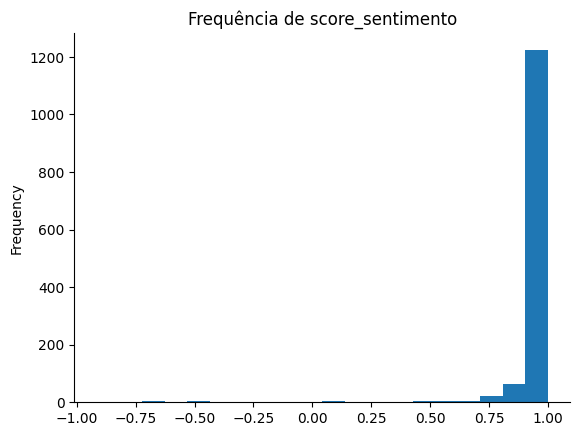

In [ ]:
# Gráfico da frequência do score de sentimento

from matplotlib import pyplot as plt
df['score_sentimento'].plot(kind='hist', bins=20, title='Frequência de score_sentimento')
plt.gca().spines[['top', 'right',]].set_visible(False)

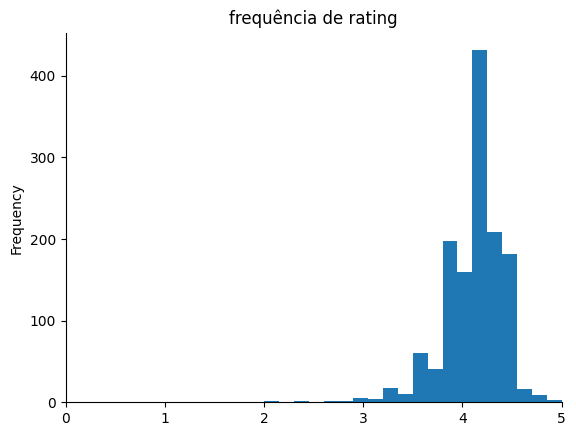

In [ ]:
# Gráfico da frequência da avaliação do cliente (rating)

query = """
SELECT
  product_id,
  score_sentimento,
  SAFE_CAST(rating AS FLOAT64) AS rating
FROM
  `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])

from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', bins=20, title='frequência de rating')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlim(0, 5)
plt.show()

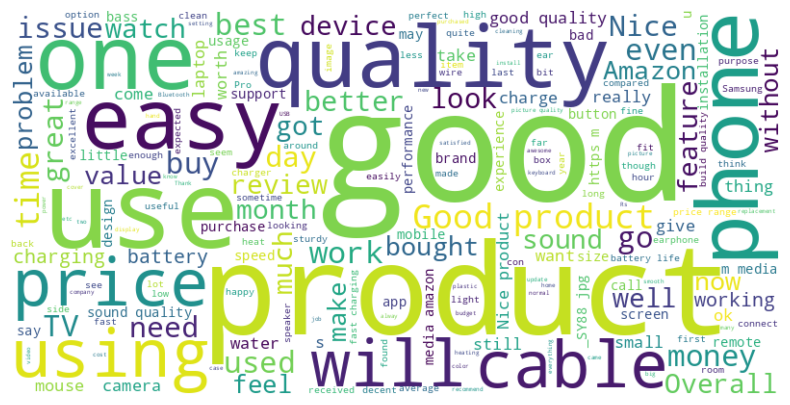

In [ ]:
# Criação da wordcloud

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT review_content
FROM `projeto04-amazon.amazon.amazon_dummy`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])

# Concatenar todas as strings da coluna 'review_content' em uma única string
text = ' '.join(df['review_content'].tolist())

# Gerar a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Análise exploratória

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1347 entries, 0 to 1347
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1347 non-null   object 
 1   product_name         1347 non-null   object 
 2   category_limpa       1347 non-null   object 
 3   discounted_price     1347 non-null   float64
 4   actual_price         1347 non-null   float64
 5   discount_percentage  1347 non-null   float64
 6   about_product        1347 non-null   object 
 7   user_name            1347 non-null   object 
 8   img_link_dummy       1347 non-null   int64  
 9   product_link_dummy   1347 non-null   int64  
 10  rating               1347 non-null   float64
 11  rating_count         1345 non-null   float64
 12  score_sentimento     1347 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 147.3+ KB


In [ ]:
df.describe()

,discounted_price,actual_price,discount_percentage,img_link_dummy,product_link_dummy,rating,rating_count,score_sentimento
count,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1345.000000,1347.000000
mean,3292.628931,5663.021990,0.466889,0.659985,0.659985,4.091759,17650.982156,0.942829
std,7159.747986,11163.488298,0.216309,0.473890,0.473890,0.297661,42189.054770,0.183380
min,39.000000,39.000000,0.000000,0.000000,0.000000,2.000000,2.000000,-0.914300
25%,349.000000,899.000000,0.310000,0.000000,0.000000,3.900000,1106.000000,0.962600
50%,893.000000,1750.000000,0.490000,1.000000,1.000000,4.100000,4740.000000,0.982600
75%,2174.000000,4575.000000,0.620000,1.000000,1.000000,4.300000,16020.000000,0.991700
max,77990.000000,139900.000000,0.940000,1.000000,1.000000,5.000000,426973.000000,0.999800


In [ ]:
# Média, mediana, desvio padrão, máximos e mínimos

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

numeric_df = df.select_dtypes(include=['float64', 'int64'])

summary = numeric_df.agg(['mean', 'median', 'std', 'min', 'max'])

summary = summary.round(2)

print(summary)


        discounted_price  actual_price  discount_percentage  img_link_dummy  \
mean             3292.63       5663.02                 0.47            0.66   
median            893.00       1750.00                 0.49            1.00   
std              7159.75      11163.49                 0.22            0.47   
min                39.00         39.00                 0.00            0.00   
max             77990.00     139900.00                 0.94            1.00   

        product_link_dummy  rating  rating_count  score_sentimento  
mean                  0.66    4.09      17650.98              0.94  
median                1.00    4.10       4740.00              0.98  
std                   0.47    0.30      42189.05              0.18  
min                   0.00    2.00          2.00             -0.91  
max                   1.00    5.00     426973.00              1.00  


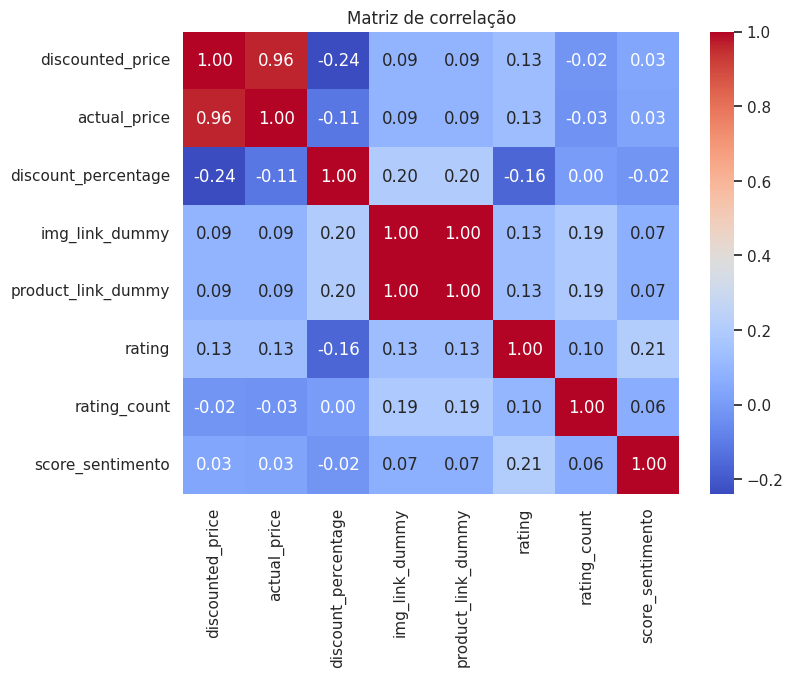

In [ ]:
# Matriz de correlação

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

numerical_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlação')
plt.show()

Boxplot de categoria em relação ao rating

  category_limpa rating
0    Electronics      3
1    Electronics      3
2    Electronics    2.8
3    Electronics    3.2
4   Home&Kitchen    3.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   category_limpa  1348 non-null   object
 1   rating          1348 non-null   object
dtypes: object(2)
memory usage: 21.2+ KB
None
  category_limpa  rating
0    Electronics     3.0
1    Electronics     3.0
2    Electronics     2.8
3    Electronics     3.2
4   Home&Kitchen     3.1
<class 'pandas.core.frame.DataFrame'>
Index: 1347 entries, 0 to 1347
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category_limpa  1347 non-null   object 
 1   rating          1347 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.6+ KB
None


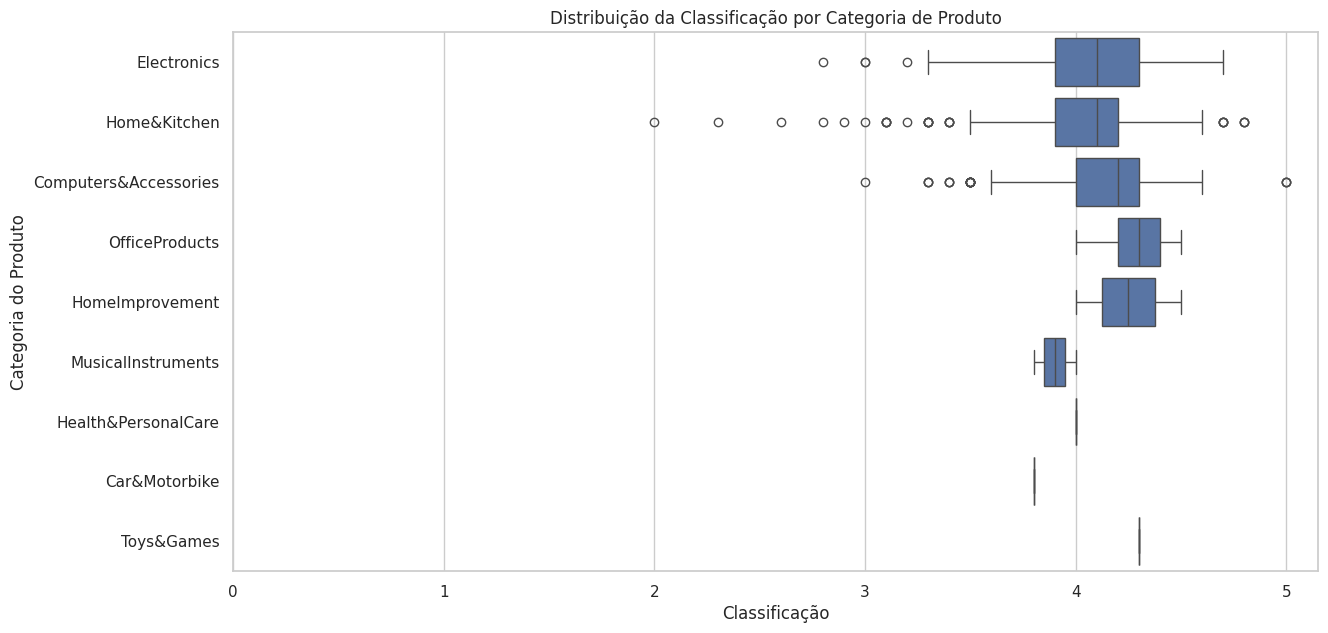

In [ ]:
!pip install seaborn matplotlib pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT category_limpa, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()
df = pd.DataFrame([dict(row) for row in results])

print(df.head())
print(df.info())

df['rating'] = df['rating'].replace('', pd.NA)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remover linhas com valores nulos em 'rating'
df = df.dropna(subset=['rating'])

print(df.head())
print(df.info())

# Configurar o estilo dos gráficos
sns.set(style="whitegrid")

# Criar o gráfico de boxplot para 'rating' por 'category_limpa'
plt.figure(figsize=(14, 7))
sns.boxplot(x='rating', y='category_limpa', data=df, orient='h')

# Ajustar o eixo X para mostrar valores inteiros de 0 a 5
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])

plt.title('Distribuição da Classificação por Categoria de Produto')
plt.xlabel('Classificação')
plt.ylabel('Categoria do Produto')
plt.show()



Verificando os produtos com maiores e menores preços dentro de cada categoria, bem como o valor médio.

In [ ]:
import pandas as pd
from google.colab import auth
from google.cloud import bigquery


auth.authenticate_user()
project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT category_limpa, actual_price, product_name
FROM `projeto04-amazon.amazon.amazon_tratada`
"""


query_job = client.query(query)
results = query_job.result()
df = pd.DataFrame([dict(row) for row in results])

# Agrupar e agregar os dados
agg_df = df.groupby('category_limpa').agg(
    preco_medio=('actual_price', 'mean'),
    preco_minimo=('actual_price', 'min'),
    preco_maximo=('actual_price', 'max')
).reset_index()

# Identificar os produtos com o menor e maior preço dentro de cada categoria
min_price_product = df.loc[df.groupby('category_limpa')['actual_price'].idxmin()]
min_price_product = min_price_product[['category_limpa', 'product_name', 'actual_price']]

# Corrigir os nomes das colunas para correspondem ao DataFrame
min_price_product.columns = ['category_limpa', 'produto_menor_preço', 'preço_menor']

max_price_product = df.loc[df.groupby('category_limpa')['actual_price'].idxmax()]
max_price_product = max_price_product[['category_limpa', 'product_name', 'actual_price']]
max_price_product.columns = ['category_limpa', 'produto_maior_preço', 'preço_maior']

# Mesclar os DataFrames
final_df = pd.merge(agg_df, min_price_product, on='category_limpa')
final_df = pd.merge(final_df, max_price_product, on='category_limpa')

# Remover colunas duplicadas geradas pela mesclagem
final_df = final_df.drop(columns=['preço_menor', 'preço_maior'])

final_df


,category_limpa,preco_medio,preco_minimo,preco_maximo,produto_menor_preço,produto_maior_preço
0,Car&Motorbike,4000.000000,4000.0,4000.0,Reffair AX30 [MAX] Portable Air Purifier for C...,Reffair AX30 [MAX] Portable Air Purifier for C...
1,Computers&Accessories,1853.621979,39.0,59890.0,Inventis 5V 1.2W Portable Flexible USB LED Lig...,"Lenovo IdeaPad 3 11th Gen Intel Core i3 15.6"" ..."
2,Electronics,10333.069530,171.0,139900.0,Goldmedal Curve Plus 202042 Plastic Spice 3-Pi...,Sony Bravia 164 cm (65 inches) 4K Ultra HD Sma...
3,Health&PersonalCare,1900.000000,1900.0,1900.0,Dr Trust Electronic Kitchen Digital Scale Weig...,Dr Trust Electronic Kitchen Digital Scale Weig...
4,Home&Kitchen,4165.120805,79.0,75990.0,Kitchenwell 18Pc Plastic Food Snack Bag Pouch ...,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...
5,HomeImprovement,799.000000,599.0,999.0,"Gizga Essentials Cable Organiser, Cord Managem...",ESnipe Mart Worldwide Travel Adapter with Buil...
6,MusicalInstruments,1347.000000,699.0,1995.0,MAONO AU-400 Lavalier Auxiliary Omnidirectiona...,Boya ByM1 Auxiliary Omnidirectional Lavalier C...
7,OfficeProducts,397.193548,50.0,2999.0,Classmate Octane Neon- Blue Gel Pens(Pack of 5...,Portronics Ruffpad 15 Re-Writable LCD Screen 3...
8,Toys&Games,150.000000,150.0,150.0,Faber-Castell Connector Pen Set - Pack of 25 (...,Faber-Castell Connector Pen Set - Pack of 25 (...


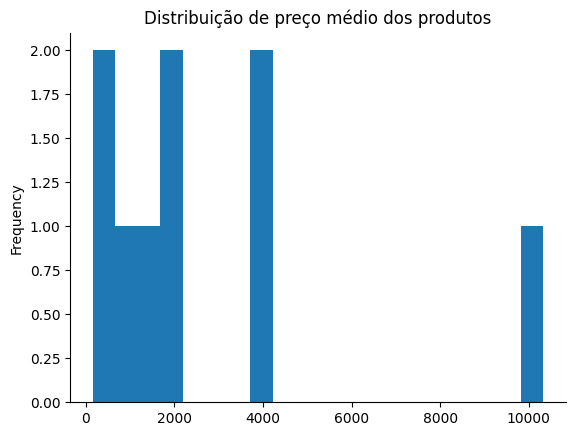

In [ ]:
# Distribuição de preço médio dos produtos

from matplotlib import pyplot as plt
final_df['preco_medio'].plot(kind='hist', bins=20, title='Distribuição de preço médio dos produtos')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Teste de hipótese:

Hipótese 1: produtos com maior desconto aplicado (discount_percentage) são melhor classificados (rating);

Hipótese 2: produtos com mais avaliações positivas (score_sentimento) são melhor classificados (rating);

Hipótese 3: produtos com mais avaliações (rating_count) são melhores classificados (rating);


## *Hipótese 1*

Teste de normalidade para a hipótese 1

In [ ]:
import pandas as pd
from scipy.stats import shapiro
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT discount_percentage, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

# Separar os dados em duas variáveis diferentes
dados_desconto = df['discount_percentage']
# Convert 'rating' to numeric, replacing non-convertible values with NaN
dados_rating = pd.to_numeric(df['rating'].str.replace('|', '', regex=False), errors='coerce')
# Remove NaN values from 'dados_rating'
dados_rating = dados_rating.dropna()

# Shapiro para discount_percentage
estatistica_shapiro_desconto, p_valor_desconto = shapiro(dados_desconto)

# Printar os resultados para discount_percentage
print(f'Estatísticas de Shapiro para discount_percentage: {estatistica_shapiro_desconto}')
print(f'P-valor para discount_percentage: {p_valor_desconto}')

# Shapiro para rating
shapiro_rating, p_valor_rating = shapiro(dados_rating)

# Printar os resultados para rating
print(f'Estatísticas de Shapiro para rating: {shapiro_rating}')
print(f'P-valor para rating: {p_valor_rating}')


# Interpretando os resultados para discount_percentage
alpha = 0.05
if p_valor_desconto > alpha:
    print('Os dados parecem seguir uma distribuição normal.')
else:
    print('Os dados parecem não seguir uma distribuição normal.')

# Interpretando os resultados para rating
if p_valor_rating > alpha:
    print('Os dados parecem seguir uma distribuição normal.')
else:
    print('Os dados parecem não seguir uma distribuição normal.')

Estatísticas de Shapiro para discount_percentage: 0.982800304889679
P-valor para discount_percentage: 1.4021724753510156e-11
Estatísticas de Shapiro para rating: 0.9263893961906433
P-valor para rating: 3.592355712354902e-25
Os dados parecem não seguir uma distribuição normal.
Os dados parecem não seguir uma distribuição normal.


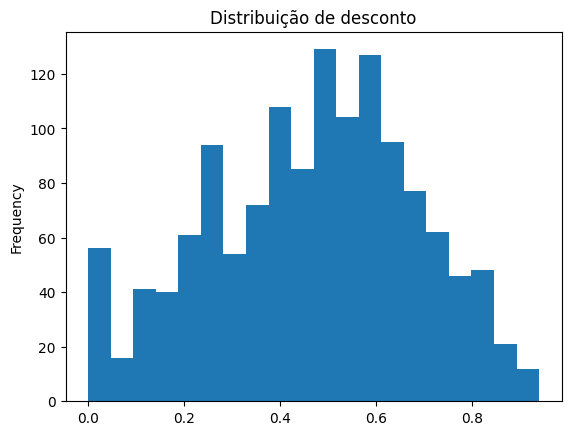

In [ ]:
# Histograma de desconto
import matplotlib.pyplot as plt
import pandas as pd

df['discount_percentage'].plot(kind='hist', bins=20, title='Distribuição de desconto')
plt.show()

Teste de correlação para a hipótese 1

O valor da correlação é -0.1508, indicando uma correlação negativa fraca entre a classificação ("rating") e o percentual de desconto ("discount_percentage"). Isso sugere que, de maneira geral, produtos com maior desconto tendem a ter uma classificação ligeiramente mais baixa, mas a relação é fraca.
O p-valor é muito pequeno (menor que 0.05), o que indica que a correlação observada é estatisticamente significativa. Portanto, rejeitamos a hipótese nula de que não há correlação entre as duas variáveis e concluímos que há uma correlação significativa, mesmo que fraca.

In [ ]:
from scipy.stats import spearmanr
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT discount_percentage, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

# Separar os dados em duas variáveis diferentes
discount_percentage = df['discount_percentage']

# Convertendo 'rating' para numérico e corrigindo
rating = pd.to_numeric(df['rating'].str.replace('|', '', regex=False), errors='coerce')

# Criando um dataframe
df_cleaned = pd.DataFrame({'discount_percentage': discount_percentage, 'rating': rating})
df_cleaned = df_cleaned.dropna()  # Remover linhas com valores NaN em mabas colunas

# Extraindo as séries limpas
discount_percentage = df_cleaned['discount_percentage']
rating = df_cleaned['rating']

# Spearman para as variáveis discount_percentage e rating
correlation, p_value = spearmanr(discount_percentage, rating)
print(f'Correlação de Spearman: {correlation}, p-value: {p_value}')

# Comparar com alpha (0.05)
alpha = 0.05
if p_value < alpha:
    print("Rejeita a hipótese nula. Há uma correlação significativa.")
else:
    print("Não há evidência suficiente para rejeitar a hipótese nula, ou seja, não há uma correlação significativa.")

Correlação de Spearman: -0.15078229854037317, p-value: 2.688203658485133e-08
Rejeita a hipótese nula. Há uma correlação significativa.


Teste de significância para a hipótese 1

O teste de Mann-Whitney mostra que existe uma diferença significativa entre os grupos "alto" e "baixo" de percentual de desconto. Isso implica que a distribuição das classificações é diferente entre os dois grupos, e essa diferença é estatisticamente significativa.

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = pd.read_csv('/content/amazon_tratada.csv')

# Definindo um ponto de corte para alta e baixa porcentagem de desconto (0.50)
alta_group = df[df['discount_percentage'] > 0.5]['rating_corrigido']
baixa_group = df[df['discount_percentage'] <= 0.5]['rating_corrigido']

# Teste de Mann-Whitney U
estatistica, p_value = mannwhitneyu(alta_group, baixa_group, alternative='two-sided')

# Imprimir os resultados
print(f"Mann-Whitney U statistic: {estatistica:.4f}")
print(f"P-value: {p_value:.4f}")

# Verifique se o p-value é significativo (por exemplo, menor que 0.05)
if p_value < 0.05:
    print("A diferença entre os grupos 'alto' e 'baixo' do percentual de desconto é estatisticamente significativo.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos 'alto' e 'baixo' do percentual de desconto.")

Mann-Whitney U statistic: 194847.5000
P-value: 0.0000
A diferença entre os grupos 'alto' e 'baixo' do percentual de desconto é estatisticamente significativo.


Regressão linear para a hipótese 1

O R² indica que apenas 3.1% da variação na variável dependente (rating) é explicada pelo modelo. Este é um valor bastante baixo, sugerindo que o modelo explica muito pouco da variação na classificação dos produtos.

O modelo de regressão linear mostra que o percentual de desconto tem um impacto estatisticamente significativo sobre a classificação dos produtos, com uma correlação negativa. No entanto, o baixo valor de R² indica que o modelo não explica bem a variação na variável dependente. Isso sugere que, embora o desconto tenha um efeito significativo, há muitos outros fatores que também influenciam a classificação dos produtos e que não estão sendo considerados neste modelo.

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     34.75
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           5.01e-09
Time:                        14:29:29   Log-Likelihood:                -237.75
No. Observations:                1077   AIC:                             479.5
Df Residuals:                    1075   BIC:                             489.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.2108    

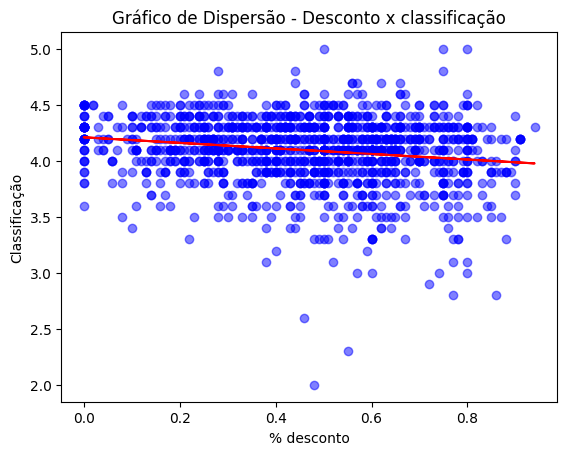

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

df = df.dropna(subset=['discount_percentage', 'rating'])

# Selecionar as variáveis independentes (X) e dependente (y)
X = df[['discount_percentage']]  # Variável independente
y = df['rating']  # Variável dependente

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Adicionar uma constante ao X (intercepto)
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo de regressão linear
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Printar o sumário do modelo
print(model_sm.summary())

# Plotar o gráfico de dispersão
plt.scatter(df['discount_percentage'], df['rating'], alpha=0.5, color='blue')
plt.title('Gráfico de Dispersão - Desconto x classificação')
plt.xlabel('% desconto')
plt.ylabel('Classificação')
plt.plot(df['discount_percentage'], model.predict(X), color='red')
plt.show()

## *Hipótese 2*

Teste de normalidade para a hipótese 2

In [ ]:
# Shapiro-Wilk

import pandas as pd
from scipy.stats import shapiro
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT score_sentimento
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

dados_sentimento = df['score_sentimento']

# Remove NaN values from 'dados_sentimento'
dados_sentimento = dados_sentimento.dropna()

# Shapiro para score_sentimento
estatistica_shapiro_sentimento, p_valor_sentimento = shapiro(dados_sentimento)

# Printar os resultados para discount_percentage
print(f'Estatísticas de Shapiro para score_sentimento: {estatistica_shapiro_sentimento}')
print(f'P-valor para score_entimento: {p_valor_sentimento}')

# Interpretando os resultados para score_sentimento
alpha = 0.05
if p_valor_desconto > alpha:
    print('Os dados parecem seguir uma distribuição normal.')
else:
    print('Os dados parecem não seguir uma distribuição normal.')



Estatísticas de Shapiro para score_sentimento: 0.2596701979637146
P-valor para score_entimento: 0.0
Os dados parecem não seguir uma distribuição normal.


Correlação para a hipótese 2

O valor de 0.2652 sugere uma correlação positiva moderada entre score_sentimento e rating. De maneira geral, quando o nível de satisfação do cliente (score_sentimento) aumenta, a classificação dos produtos (rating) também tende a aumentar. A correlação positiva indica que há uma tendência geral de que uma maior satisfação está associada a melhores classificações.

O valor p é menor que 0.05. Isso indica que a correlação observada é estatisticamente significativa.

In [ ]:
# Correlação de Spearman
from scipy.stats import spearmanr
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT score_sentimento, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

# Separar os dados em duas variáveis diferentes
score_sentimento = df['score_sentimento']

# Convertendo 'rating' para numérico e corrigindo
rating = pd.to_numeric(df['rating'].str.replace('|', '', regex=False), errors='coerce')

# Criando um dataframe
df_cleaned = pd.DataFrame({'score_sentimento': score_sentimento, 'rating': rating})
df_cleaned = df_cleaned.dropna()  # Remover linhas com valores NaN em mabas colunas

# Extraindo as séries limpas
score_sentimento = df_cleaned['score_sentimento']
rating = df_cleaned['rating']

# Spearman para as variáveis discount_percentage e rating
correlation, p_value = spearmanr(score_sentimento, rating)
print(f'Correlação de Spearman: {correlation}, p-value: {p_value}')

# Comparar com alpha (0.05)
alpha = 0.05
if p_value < alpha:
    print("Rejeita a hipótese nula. Há uma correlação significativa.")
else:
    print("Não há evidência suficiente para rejeitar a hipótese nula, ou seja, não há uma correlação significativa.")

Correlação de Spearman: 0.2651541586980413, p-value: 4.1521813674247753e-23
Rejeita a hipótese nula. Há uma correlação significativa.


Teste de significância para a hipótese 2

O valor p é > 0.05. Isso indica que o teste de Mann-Whitney não mostrou diferença estatisticamente significativa entre os ratings atribuídos aos produtos com alto e baixo score de sentimento. Isso sugere que enquanto há uma tendência de que produtos com avaliações melhores tenham ratings mais altos, essa relação não é suficientemente forte para ser detectada de maneira conclusiva entre os grupos de produtos com diferentes níveis de score de sentimento. Portanto, os resultados indicam que há uma correlação positiva modesta entre a avaliação dos clientes (score_sentimento) e os ratings dos produtos, porém essa correlação não se traduz em uma diferença estatisticamente significativa nos ratings entre produtos com alto e baixo score de sentimento







In [2]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = pd.read_csv('/content/amazon_tratada.csv')

# Definindo um ponto de corte para alta e baixa score_sentimento (0.0)
alta_group = df[df['score_sentimento'] > 0.0]['rating_corrigido']
baixa_group = df[df['score_sentimento'] <= 0.0]['rating_corrigido']

# Teste de Mann-Whitney U
estatistica, p_value = mannwhitneyu(alta_group, baixa_group, alternative='two-sided')

# Imprimindo os resultados
print(f"Mann-Whitney U statistic: {estatistica:.4f}")
print(f"P-value: {p_value:.4f}")

# Verificando se o p-value é significativo (menor que 0.05)
if p_value < 0.05:
    print("A diferença entre os grupos 'alto' e 'baixo' do score de sentimento é estatisticamente significativo.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos 'alto' e 'baixo' do score de sentimento.")

Mann-Whitney U statistic: 13200.0000
P-value: 0.0977
Não há diferença estatisticamente significativa entre os grupos 'alto' e 'baixo' do score de sentimento.


Regressão linear para a hipótese 2

O R² indica que aproximadamente 5.1% da variação na variável dependente rating é explicada pelo modelo (ou seja, pela variável independente score_sentimento). Esse é um valor relativamente baixo, sugerindo que o modelo não explica muita variação na classificação dos produtos. A maioria da variação no rating não é explicada por score_sentimento, indicando que há muitos outros fatores além de score_sentimento que afetam a classificação dos produtos. O modelo é estatisticamente significativo (p: 0.000), o que indica que score_sentimento tem uma relação significativa com rating, mas o impacto explicativo geral é limitado.

Embora o score_sentimento tenha uma influência estatisticamente significativa sobre o rating, o modelo de regressão linear mostra que essa influência é relativamente pequena, explicando apenas uma pequena fração da variação na classificação dos produtos. Isso sugere que outros fatores além da satisfação do cliente também têm um impacto importante nas classificações dos produtos.

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     57.81
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           6.26e-14
Time:                        16:51:16   Log-Likelihood:                -226.67
No. Observations:                1077   AIC:                             457.3
Df Residuals:                    1075   BIC:                             467.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.7421      0.047  

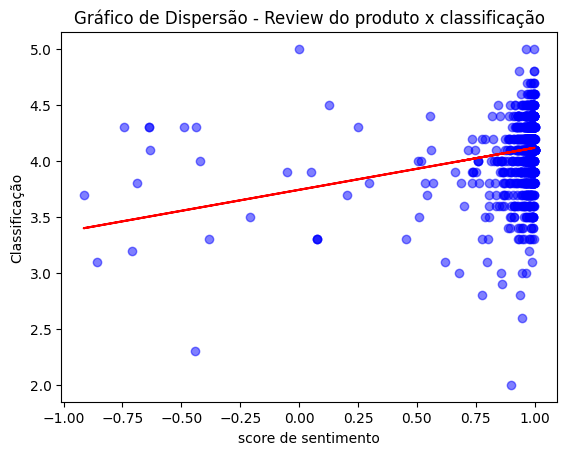

In [ ]:
#Regressão linear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Corrigindo rating
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['score_sentimento', 'rating'])

# Selecionar as variáveis independentes (X) e dependente (y)
X = df[['score_sentimento']]  # Variável independente
y = df['rating']  # Variável dependente

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Adicionar uma constante ao X (intercepto)
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo de regressão linear
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Printar o sumário do modelo
print(model_sm.summary())

# Plotar o gráfico de dispersão
plt.scatter(df['score_sentimento'], df['rating'], alpha=0.5, color='blue')
plt.title('Gráfico de Dispersão - Review do produto x classificação')
plt.xlabel('score de sentimento')
plt.ylabel('Classificação')
plt.plot(df['score_sentimento'], model.predict(X), color='red')
plt.show()

## *Hipótese 3*

Teste de  normalidade para a hipótese 3

In [ ]:
import pandas as pd
from scipy.stats import shapiro
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT rating_count
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

dados_rating_count = df['rating_count']

# Remove NaN values from 'rating_count'
dados_rating_count = dados_rating_count.dropna()

# Shapiro para rating_count
estatistica_shapiro_rating_count, p_valor_rating_count = shapiro(dados_rating_count)

# Printar os resultados para rating_count
print(f'Estatísticas de Shapiro para rating_count: {estatistica_shapiro_rating_count}')
print(f'P-valor para rating_count: {p_valor_rating_count}')

# Interpretando os resultados para rating_count
alpha = 0.05
if p_valor_desconto > alpha:
    print('Os dados parecem seguir uma distribuição normal.')
else:
    print('Os dados parecem não seguir uma distribuição normal.')

Estatísticas de Shapiro para rating_count: 0.406119167804718
P-valor para rating_count: 0.0
Os dados parecem não seguir uma distribuição normal.


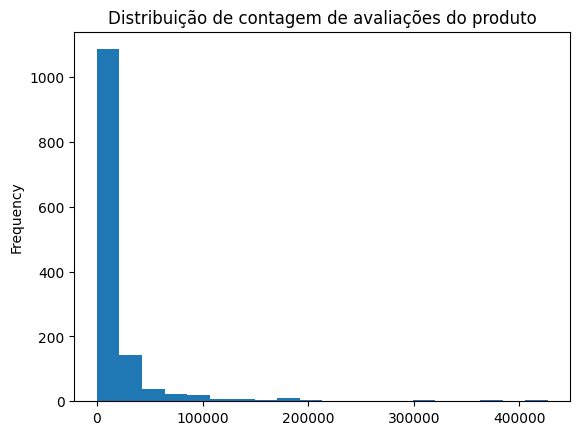

In [ ]:
# Histograma de desconto
import matplotlib.pyplot as plt
import pandas as pd

df['rating_count'].plot(kind='hist', bins=20, title='Distribuição de contagem de avaliações do produto')
plt.show()

Teste de correlação para a hipótese 3

p (p-value): 1.1511e-12, indica que a correlação observada é estatisticamente significativa.

Há uma relação estatisticamente significativa entre a contagem de avaliações e a classificação dos produtos. Produtos com mais avaliações tendem a ter uma classificação ligeiramente mais alta, mas a força dessa relação não é muito alta.

In [ ]:
# Correlação de Spearman
from scipy.stats import spearmanr
import pandas as pd
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT rating_count, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

# Separar os dados em duas variáveis diferentes
score_sentimento = df['rating_count']

# Convertendo 'rating' para numérico e corrigindo
rating = pd.to_numeric(df['rating'].str.replace('|', '', regex=False), errors='coerce')

# Criando um dataframe
df_cleaned = pd.DataFrame({'rating_count': score_sentimento, 'rating': rating})
df_cleaned = df_cleaned.dropna()  # Remover linhas com valores NaN em mabas colunas

# Extraindo as séries limpas
rating_count = df_cleaned['rating_count']
rating = df_cleaned['rating']

# Spearman para as variáveis rating_count e rating
correlation, p_value = spearmanr(rating_count, rating)
print(f'Correlação de Spearman: {correlation}, p-value: {p_value}')

# Comparar com alpha (0.05)
alpha = 0.05
if p_value < alpha:
    print("Rejeita a hipótese nula. Há uma correlação significativa.")
else:
    print("Não há evidência suficiente para rejeitar a hipótese nula, ou seja, não há uma correlação significativa.")

Correlação de Spearman: 0.19226650574101048, p-value: 1.1510710016709111e-12
Rejeita a hipótese nula. Há uma correlação significativa.


Teste de significância para a hipótese 3

p (p-value): 0.0000, indica que a diferença entre os grupos 'alto' e 'baixo' na contagem de avaliações é estatisticamente significativa. Em outras palavras, as classificações dos produtos entre os grupos de alta e baixa contagem de avaliações são significativamente diferentes. Isso sugere que produtos com diferentes níveis de contagem de avaliações têm classificações significativamente diferentes.

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = pd.read_csv('/content/amazon_tratada.csv')

# Ajustando o limite para categoria alto e baixo rating_count baseado na distribuição dos dados (utilizando a mediana)
mediana = df['rating_count'].median()

alta_group = df[df['rating_count'] > mediana]['rating_corrigido']
baixa_group = df[df['rating_count'] <= mediana]['rating_corrigido']

# Execute o teste de Mann-Whitney U
estatistica, p_value = mannwhitneyu(alta_group, baixa_group, alternative='two-sided')

# Imprima os resultados
print(f"Mann-Whitney U statistic: {estatistica:.4f}")
print(f"P-value: {p_value:.4f}")

# erifique se o p-value é significativo (por exemplo, menor que 0.05)
if p_value < 0.05:
    print("A diferença entre os grupos 'alto' e 'baixo' da contagem de classificações é estatisticamente significativo.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos 'alto' e 'baixo' da contagem de classificações.")

Mann-Whitney U statistic: 269748.0000
P-value: 0.0000
A diferença entre os grupos 'alto' e 'baixo' da contagem de classificações é estatisticamente significativo.


Regressão linear para a hipótese 3

p: 0.002, indica que o coeficiente é estatisticamente significativo. Isso sugere que há uma relação significativa entre rating_count e rating.

O R² de 0.009 indica que apenas 0.9% da variação na variável dependente (rating) é explicada pelo modelo. Este valor é muito baixo, sugerindo que rating_count explica quase nada da variação na classificação dos produtos.

O coeficiente para rating_count é significativo, mas o valor do R² é muito baixo, indicando que, embora o número de avaliações tenha um efeito estatisticamente significativo na classificação dos produtos, o modelo como um todo não explica bem a variação na classificação. Isso sugere que outros fatores além do número de avaliações podem ser muito mais influentes na determinação da classificação dos produtos.


<class 'pandas.core.frame.DataFrame'>
Index: 1345 entries, 0 to 1347
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating_count  1345 non-null   float64
 1   rating        1345 non-null   float64
dtypes: float64(2)
memory usage: 31.5 KB
None
   rating_count  rating
0         103.0     3.0
1         681.0     3.0
2          87.0     2.8
3         285.0     3.2
4        2449.0     3.1
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     9.557
Date:                Wed, 10 Jul 2024   Prob (F-statistic):            0.00204
Time:                        18:03:12   Log-Likelihood:                -236.92
No. Observations:                1076   AIC:                   

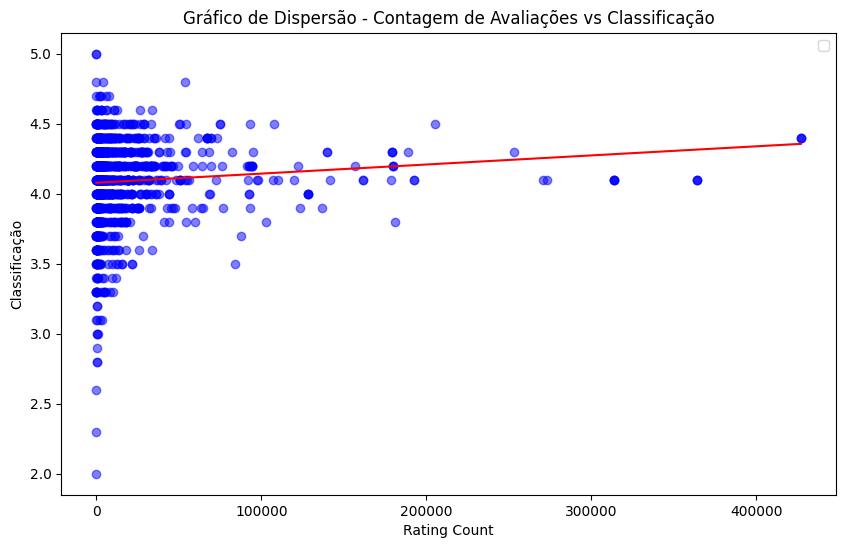

In [ ]:
# Regressão linear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT rating_count, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.DataFrame([dict(row) for row in results])

# Converter para numérico e verificar valores não numéricos
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

# Remover linhas com valores ausentes
df = df.dropna(subset=['rating_count', 'rating'])

# Verificar se há valores não numéricos ou inconsistências
print(df.info())
print(df.head())

# Selecionar as variáveis independentes (X) e dependente (y)
X = df[['rating_count']]
y = df['rating']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Adicionar uma constante ao X (intercepto) para statsmodels
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo de regressão linear com statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Printar o sumário do modelo
print(model_sm.summary())

# Gerar previsões para o conjunto de teste
X_test_sm = sm.add_constant(X_test)
y_pred = model_sm.predict(X_test_sm)

# Calcular e imprimir o erro quadrático médio
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plotar o gráfico de dispersão e a linha de regressão
plt.figure(figsize=(10, 6))

# Gráfico de dispersão
plt.scatter(df['rating_count'], df['rating'], alpha=0.5, color='blue')

# Criar um intervalo de valores de rating_count para a linha de regressão
x_range = np.linspace(df['rating_count'].min(), df['rating_count'].max(), 100).reshape(-1, 1)
x_range_sm = sm.add_constant(x_range)  # Adicionar constante
y_range = model_sm.predict(x_range_sm)  # Previsões para a linha de regressão

plt.plot(x_range, y_range, color='red')

plt.title('Gráfico de Dispersão - Contagem de Avaliações vs Classificação')
plt.xlabel('Rating Count')
plt.ylabel('Classificação')
plt.legend()
plt.show()


# *Regressão Logística*

Regressão logística para verificar a probabilidade da presença da imagem do produto (img_link) gerar avaliação positiva (rating) dos produtos.

- Verdadeiros Positivos (TP): 41 (produtos com imagem e classificação positiva);
- Falsos Positivos (FP): 49 (produtos com imagem, mas classificação negativa);
- Verdadeiros Negativos (TN): 121 (produtos sem imagem e classificação negativa);
- Falsos Negativos (FN): 59 (produtos sem imagem, mas classificação positiva).

O modelo de regressão logística tem um desempenho moderado, com uma exatidão de 60% e uma capacidade de discriminação ligeiramente melhor que o acaso (AUC-ROC de 0.561). A precisão e o recall são relativamente baixos, indicando que o modelo tem dificuldade em identificar corretamente todos os casos positivos e tem uma taxa alta de falsos positivos.

A acurácia semelhante no conjunto de treino e no conjunto de teste sugere que o modelo está bem ajustado e não apresenta overfitting significativo.

O F1-score baixo e o Log-Loss relativamente alto indicam que o modelo não está fazendo previsões muito confiáveis.



rating_dummy
0    170
1    100
Name: count, dtype: int64


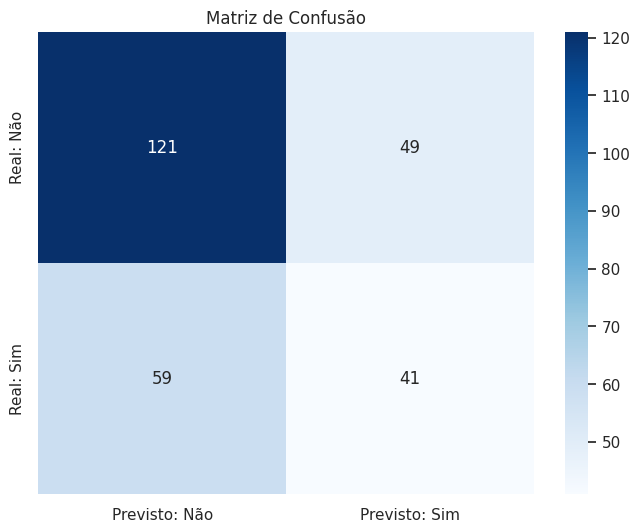

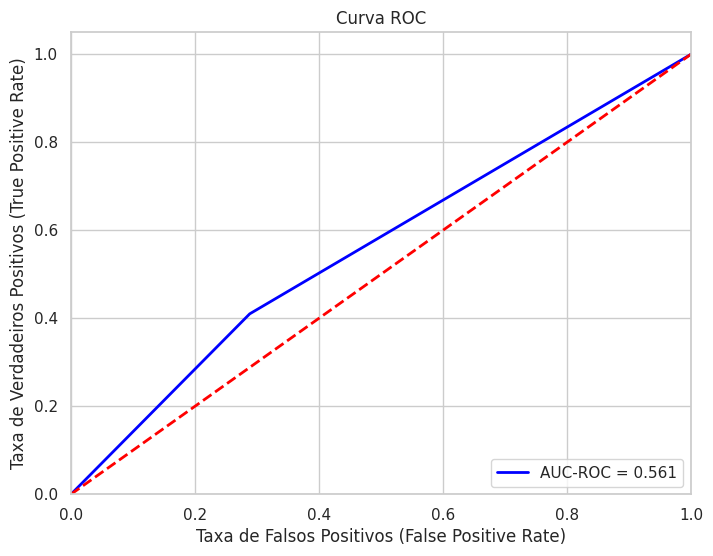

Regressão Logística:
[[121  49]
 [ 59  41]]

Métricas de Avaliação:
Exatidão (Accuracy): 0.600
Precisão: 0.456
Sensibilidade (Recall): 0.410
F1-score: 0.432
AUC-ROC: 0.561
Log-Loss: 0.685
Acurácia no conjunto de treino: 0.582
Acurácia no conjunto de teste: 0.600


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, log_loss, roc_curve
from google.colab import auth
from google.cloud import bigquery


auth.authenticate_user()
project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT img_link_dummy, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()


df = pd.DataFrame([dict(row) for row in results])

# Converter a coluna 'rating' para numérico e lidar com valores não numéricos
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remover linhas com valores ausentes
df = df.dropna(subset=['rating'])

# Criar a variável dummy para a classificação (ajustado conforme o critério fornecido)
df['rating_dummy'] = df['rating'].apply(lambda x: 0 if x > 4 else 1)

# Separar as características (X) e a variável dependente (y)
X = df[['img_link_dummy']]  # Característica: se o produto tem imagem ou não
y = df['rating_dummy']  # Variável dependente: 0 (rating > 4) ou 1 (rating <= 4)

# Dividir os dados em conjunto de treino e teste, estratificando por 'rating_dummy'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Verificar a distribuição das classes no conjunto de teste
print(y_test.value_counts())

# Estandarizar as características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criar o modelo de regressão logística
model = LogisticRegression(class_weight='balanced')

# Treinar o modelo
model.fit(X_train, y_train)

# Realizar predições no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calcular métricas de avaliação
tn, fp, fn, tp = conf_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

# Calcular AUC-ROC e Log-Loss
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
log_loss_value = log_loss(y_test, model.predict_proba(X_test))

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

# Calcular e exibir a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto: Não', 'Previsto: Sim'], yticklabels=['Real: Não', 'Real: Sim'])
plt.title('Matriz de Confusão')
plt.show()

# Visualização da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC-ROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir resultados
print("\033[1mRegressão Logística:\033[0m")
print(conf_matrix)

print("\n\033[1mMétricas de Avaliação:\033[0m")
print(f"Exatidão (Accuracy): {accuracy:.3f}")
print(f"Precisão: {precision:.3f}")
print(f"Sensibilidade (Recall): {sensitivity:.3f}")
print(f"F1-score: {f1_score:.3f}")
print(f"AUC-ROC: {roc_auc:.3f}")
print(f"Log-Loss: {log_loss_value:.3f}")

# Avaliar o modelo nos dados de treino e teste
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia no conjunto de treino: {train_accuracy:.3f}')
print(f'Acurácia no conjunto de teste: {test_accuracy:.3f}')


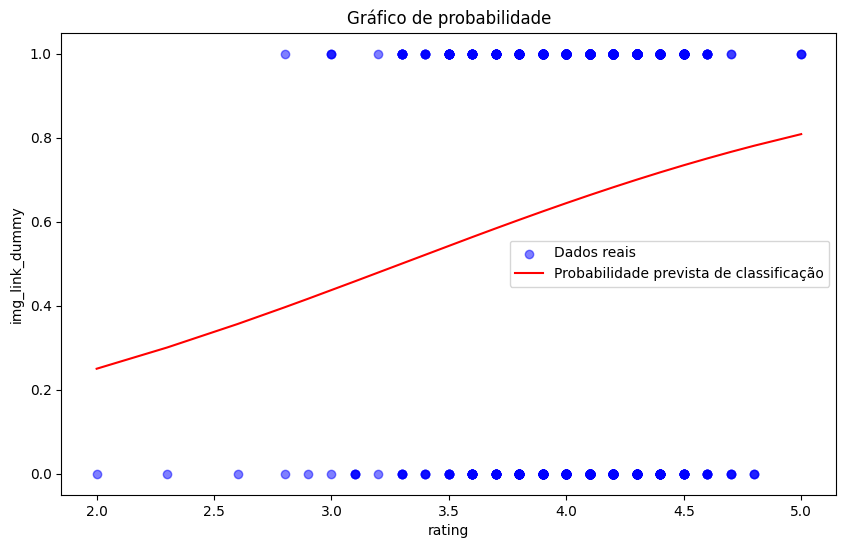

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

auth.authenticate_user()

project_id = "projeto04-amazon"
client = bigquery.Client(project=project_id)

query = """
SELECT img_link_dummy, rating
FROM `projeto04-amazon.amazon.amazon_tratada`
"""

query_job = client.query(query)
results = query_job.result()

df = pd.read_gbq(query, project_id=project_id, dialect="standard")

# Converter a coluna 'rating' para numérica, tratando valores não numéricos.
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remover linhas com valores ausentes em 'rating'
df = df.dropna(subset=['rating'])

# Modelo de regressão logística
logistic_model = LogisticRegression()
logistic_model.fit(df[['rating']], df['img_link_dummy'])

probabilities = logistic_model.predict_proba(df[['rating']])[:, 1]

# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 6))

# Pontos de dados reais
plt.scatter(df['rating'], df['img_link_dummy'], alpha=0.5, color='blue', label='Dados reais')

# Adicionando a curva de probabilidade da regressão logística
sorted_indices = np.argsort(df['rating'])
sorted_score_dummy = df['rating'].iloc[sorted_indices]
sorted_probabilities = probabilities[sorted_indices]
plt.plot(sorted_score_dummy, sorted_probabilities, color='red', label='Probabilidade prevista de classificação')

plt.title('Gráfico de probabilidade')
plt.xlabel('rating')
plt.ylabel('img_link_dummy')
plt.legend()

plt.show()